<a href="https://colab.research.google.com/github/laurakn/undergrad_research_2022/blob/ruoyu/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Define the parameters

In [2]:
# copy file path
TRAIN_DATASET_PATH = '/content/drive/MyDrive/Research/Fairness/code/dataset/adult_income/adult.data'
TEST_DATASET_PATH = '/content/drive/MyDrive/Research/Fairness/code/dataset/adult_income/adult.test'
NAME_DATASET_PATH = '/content/drive/MyDrive/Research/Fairness/code/dataset/adult_income/adult.names'

# define the column name of the dataset, required
column_name = ["age", "workClass", "fnlwgt", "education", "education-num","marital-status", "occupation", "relationship",
          "race", "sex", "capital-gain", "capital-loss", "hours-per-week", "native-country", "income"]


drop_na = True

# Setup

In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn import metrics

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load Dataset

In [5]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [6]:
from pandas.core.frame import DataFrame
def adult_feature_engineering(df:DataFrame):
  '''
  df['native-country']=np.where(df['native-country']==' United-States',1,0)
  df['marital-status']=np.where(df['marital-status']==' Married',1,0)
  df['workClass']=np.where(df['workClass']==' Private',1,0)
  df['sex']=np.where(df['sex']==' Male',1,0)
  df['race']=np.where(df['race']==' White',1,0)
  '''
  df = df.drop(columns=['fnlwgt'])


  # income < 50k is 0, otherwise 1
  df['sex']=np.where(df['sex']==' Male',1,0)
  df['income']=np.where(np.logical_or(df['income']==' <=50K', df['income']==' <=50K.'),0,1)
  obj_col = df.select_dtypes(include=['object'])
  
  # Not sure how to encode education, relationship, and occupation using one-hot

  df = df.drop(columns=obj_col.columns)

  #df = pd.get_dummies(df,obj_col.columns)

  return df


In [7]:
def f_load_data(TRAIN_DATASET_PATH:str,
                TEST_DATASET_PATH:str,
                drop_na:bool = True,
                column_name:list = None,
                ):
  assert(column_name != None)
  train_dataset = pd.read_csv(TRAIN_DATASET_PATH, index_col=False, header=None,
                              names=column_name)
  
  test_dataset = pd.read_csv(TEST_DATASET_PATH, index_col=False, header=None,
                             names=column_name, skiprows=1)
  
    

  print(f'shape of train: {train_dataset.shape}')
  print(f'shape of test: {test_dataset.shape}')
  
  if drop_na == True:
    train_dataset = train_dataset.replace({' ?': np.nan}).dropna()
    test_dataset = test_dataset.replace({' ?': np.nan}).dropna()

  # need ignore_index to recalculate new index
  combined_dataset = pd.concat([train_dataset,test_dataset], ignore_index=True)
  
  int_col = combined_dataset.select_dtypes(include=['int64'])
  #print(int_col.columns)


  for col in int_col:
    mean = combined_dataset[col].mean()
    std = combined_dataset[col].std()
    combined_dataset[col]=(combined_dataset[col]-mean)/std

  #scalar = StandardScaler()
  #tmp = scalar.fit_transform(combined_dataset[int_col.columns])
  #combined_dataset.drop(int_col, axis=1, inplace=True)
  #combined_dataset = np.hstack((combined_dataset.values, tmp))

  
  combined_dataset = adult_feature_engineering(combined_dataset)

  #display(combined_dataset)
  #combined_dataset.head()
  #combined_dataset.info()

  #train_dataset.info()
  #test_dataset.info()
  #train_dataset.head()
  
  #print(combined_dataset)
  #combined_dataset.head()
  index = train_dataset.shape[0]

  train_dataset = combined_dataset.iloc[:index,:]
  test_dataset = combined_dataset.iloc[index:,:]
  return train_dataset, test_dataset

train_dataset, test_dataset = f_load_data(TRAIN_DATASET_PATH, TEST_DATASET_PATH,  True, column_name)

print(f'shape of train: {train_dataset.shape}')
print(f'shape of test: {test_dataset.shape}')
display(test_dataset)

shape of train: (32561, 15)
shape of test: (16281, 15)
shape of train: (30162, 7)
shape of test: (15060, 7)


,age,education-num,sex,capital-gain,capital-loss,hours-per-week,income
30162,-1.024972,-1.221545,1,-0.146732,-0.218778,-0.078119,0
30163,-0.041455,-0.438117,1,-0.146732,-0.218778,0.754693,0
30164,-0.798006,0.737026,1,-0.146732,-0.218778,-0.078119,1
30165,0.412476,-0.046402,1,0.877457,-0.218778,-0.078119,1
30166,-0.344075,-1.613260,1,-0.146732,-0.218778,-0.910931,0
...,...,...,...,...,...,...,...
45217,-0.419730,1.128740,1,-0.146732,-0.218778,-0.078119,0
45218,0.034201,1.128740,0,-0.146732,-0.218778,-0.411244,0
45219,-0.041455,1.128740,1,-0.146732,-0.218778,0.754693,0
45220,0.412476,1.128740,1,0.579979,-0.218778,-0.078119,0


In [7]:
train_dataset.index.is_unique

True

#Model Template

In [8]:
# Template model
from sklearn.linear_model import LogisticRegression
import sklearn

class Abernethy_p_sampling(object):
  def __init__(
      self,
      classifier,
      p:float,
      initial_set_frac:float = 0.3,
      origin_train_dataset:DataFrame = None,
      origin_test_dataset:DataFrame = None,
      protected_label:str = None,
      ):
    assert(protected_label != None)
    assert(0 < p <=1)
    assert(0 < initial_set_frac <=1)
    self.protected_label = protected_label
    self.p = p
    self.origin_train_dataset = origin_train_dataset.copy()
    self.origin_test_dataset = origin_test_dataset.copy()
    self.best_classifier = sklearn.base.clone(classifier)
    self.empty_classifier = sklearn.base.clone(classifier)

    # construct the initial training set and remove them from the original set
    self.trainset = self.origin_train_dataset.sample(frac = initial_set_frac)
    self.origin_train_dataset.drop(index=self.trainset.index, inplace=True)
    
    # Need to reset index to keep everything in order
    self.origin_train_dataset.reset_index(drop=True, inplace=True)
    self.trainset.reset_index(drop=True, inplace=True)
    #display(self.trainset)
    #display(self.origin_train_dataset)
  
  def train(
      self,
      chosen_metric:str = 'Overall_accuracy',
      quiet_mode:bool = True
      ):
    self.scores_list = []
    self.metric_result_list = []
    self.run_out_time = {}
    best_score = -1

    unique_p_label = self.origin_train_dataset[self.protected_label].unique()
    for i in unique_p_label:
      self.run_out_time[i] = -1

    stop_training = False
    train_data = self.trainset.copy()
    y = train_data['income']
    X = train_data.drop('income', axis=1)
    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X,y)

    # fit the initial model and output the prediction
    c_classifier = sklearn.base.clone(self.empty_classifier)
    c_classifier.fit(X_train, y_train)
    y_pred = c_classifier.predict(X_test)

    # obtain score and fairness violation
    initial_score = c_classifier.score(X_test, y_test)
    best_score = initial_score
    self.scores_list.append(initial_score)
    metric = Fairness_metric(X_test[self.protected_label], true_label=y_test, predict_label=y_pred)
    metric.process()
    all_violation = metric.calculate_all()
    self.metric_result_list.append(all_violation)
    c_label = all_violation[chosen_metric][1]
    c_vio = all_violation[chosen_metric][2]
    if quiet_mode == False: 
      print(f'Initial Score: {initial_score}, Initial violation: {c_vio}, Initial biased group: {c_label}')
    
    #display(train_data)
    # sample from biased group
    t_random_num = np.random.uniform()
    if t_random_num < self.p:
       smp = self.origin_train_dataset[self.origin_train_dataset[self.protected_label] == c_label].sample()
       self.origin_train_dataset.drop(index=smp.index, inplace=True)
       self.origin_train_dataset.reset_index(drop=True, inplace=True)
       train_data = pd.concat([train_data, smp], ignore_index=True)
    else:
      smp = self.origin_train_dataset.sample()
      self.origin_train_dataset.drop(index=smp.index, inplace=True)
      self.origin_train_dataset.reset_index(drop=True, inplace=True)
      train_data = pd.concat([train_data, smp], ignore_index=True)

    iteration = 1
    while stop_training == False:
      y = train_data['income']
      X = train_data.drop('income', axis=1)
      X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X,y)

      # fit the initial model and output the prediction
      c_classifier = sklearn.base.clone(self.empty_classifier)
      
      c_classifier.fit(X_train, y_train)
      y_pred = c_classifier.predict(X_test)

      # obtain score and fairness violation
      c_score = c_classifier.score(X_test, y_test)
      self.scores_list.append(c_score)
      metric = Fairness_metric(X_test[self.protected_label], true_label=y_test, predict_label=y_pred)
      #print(X_test[self.protected_label])
      
      metric.process()
      all_violation = metric.calculate_all()
      self.metric_result_list.append(all_violation)
      c_label = all_violation[chosen_metric][1]
      c_vio = all_violation[chosen_metric][2]
      if quiet_mode == False and iteration % 500 == 0: 
        print(f'Score: {c_score}, violation: {c_vio}, biased group: {c_label}')

      #print(all_violation)

      
      if c_score > best_score:
        best_score = c_score
        self.best_classifier = c_classifier

      # sample from biased group
      t_random_num = np.random.uniform()
      biased_set = self.origin_train_dataset[self.origin_train_dataset[self.protected_label] == c_label]
      if len(biased_set) == 0 and self.run_out_time[c_label] == -1:
        print(f'Run out of sample for group {c_label} at iteration {iteration}')
        self.run_out_time[c_label] = iteration

      if t_random_num < self.p and len(biased_set) != 0:
        smp = self.origin_train_dataset[self.origin_train_dataset[self.protected_label] == c_label].sample()
        
        self.origin_train_dataset.drop(index=smp.index, inplace=True)
        self.origin_train_dataset.reset_index(drop=True, inplace=True)
        train_data = pd.concat([train_data, smp], ignore_index=True)
      else:
        smp = self.origin_train_dataset.sample()
        self.origin_train_dataset.drop(index=smp.index, inplace=True)
        self.origin_train_dataset.reset_index(drop=True, inplace=True)
        train_data = pd.concat([train_data, smp], ignore_index=True)

      if len(self.origin_train_dataset) == 0:
        stop_training = True
      iteration += 1


    # How to define the best classifier?
    return self.best_classifier, self.scores_list, self.metric_result_list
  
  def predict(
      self,
      ):
    return None
  
  def save(
      self,
      path:str):
    return None
  
  def load(
      self,
      path:str):
    return None

In [12]:
classifier = LogisticRegression( max_iter = 100)
model = Abernethy_p_sampling(classifier, 0.7, 0.2, train_dataset, test_dataset, 'sex')
len(train_dataset)
best_classifier, scores_list, metric_result_list = model.train(quiet_mode = False, chosen_metric='Demographic_Parity')
# The number of rows do not add up

Initial Score: 0.8216180371352785, Initial violation: [-0.17165802], Initial biased group: 0
Score: 0.8144519289650949, violation: [-0.17060742], biased group: 0
Score: 0.8208191126279863, violation: [-0.17771464], biased group: 0
Score: 0.8327137546468402, violation: [-0.16847554], biased group: 0
Score: 0.8276892430278885, violation: [-0.16419511], biased group: 0
Score: 0.8260665729020159, violation: [-0.15567219], biased group: 0
Score: 0.8286093888396812, violation: [-0.18115859], biased group: 0
Score: 0.8346621905161561, violation: [-0.14910226], biased group: 0
Score: 0.8377192982456141, violation: [-0.17266484], biased group: 0
Score: 0.8416255222180022, violation: [-0.16656549], biased group: 0
Score: 0.8430021754894851, violation: [-0.17564642], biased group: 0
Score: 0.8449531737773153, violation: [-0.17842461], biased group: 0
Score: 0.8424202127659575, violation: [-0.17107126], biased group: 0
Score: 0.8471113948292371, violation: [-0.16178249], biased group: 0
Score: 0.8

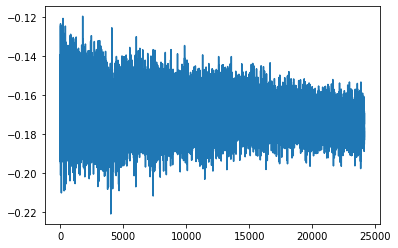

In [13]:
vio_list = []
for dict_i in metric_result_list:
  vio_list.append(dict_i['Demographic_Parity'][2])
plt.plot(vio_list)

In [216]:

smp = train_dataset[train_dataset["sex"]== 0].sample()
print(smp)
index = smp.index
print(train_dataset.iloc[index])
#print(smp.index)
train_dataset.drop(index=smp.index, inplace=True)
train_dataset.reset_index(drop=True, inplace=True)
print(train_dataset.iloc[index])

            age  ...  native-country_ Yugoslavia
12167  0.639442  ...                           0

[1 rows x 103 columns]
            age  ...  native-country_ Yugoslavia
12167  0.639442  ...                           0

[1 rows x 103 columns]
            age  ...  native-country_ Yugoslavia
12167  0.715097  ...                           0

[1 rows x 103 columns]


In [151]:
train_dataset.index.is_unique

False

# Fairness Metric

In [9]:
import numpy as np
import pandas as pd

In [10]:
#self.true_data = train_dataset[[protected_col,label_col]].to_numpy()
# true_data is |protected_label | true_y |

class Fairness_metric(object):
  def __init__(
      self,
      protected_label:list,
      true_label:list,
      predict_label:list,
      ):
    assert(len(protected_label) == len(true_label))
    assert(len(predict_label) == len(true_label))
    self.protected_label = np.array(protected_label)
    self.predict_label = np.array(predict_label)
    self.true_label = np.array(true_label)
    self.res_mat = {}
    # res_mat: 
    # key : protected label 
    # val: [TP, FP, FN, TN]
    
  def process(self):
    for key in np.unique(self.protected_label):
      self.res_mat[key] = [0,0,0,0]
      # TP, FP, FN, TN
    for i in range(len(self.predict_label)):
      tmp_prot = self.protected_label[i]
      tmp_true = self.true_label[i]
      tmp_pred = self.predict_label[i]
      if tmp_true == tmp_pred and tmp_true == 1:
        # TP
        self.res_mat[tmp_prot][0] +=1
      elif tmp_true == 1 and tmp_pred == 0:
        # FN
        self.res_mat[tmp_prot][2] +=1
      elif tmp_true == 0 and tmp_pred == 1:
        # FP
        self.res_mat[tmp_prot][1] +=1
      elif tmp_true == 0 and tmp_pred == 0:
        # TN
        self.res_mat[tmp_prot][3] +=1
      else:
        print('Incorrect Code')

  # This is for two protected labels, can be adapted to multiple protected labels
  # output an dict of scores of all labels and a list containing biased group with
  # its violation
  def Demographic_Parity(
      self,
      ):
    res = {}
    # [label : score]
    for label, tmp_list in self.res_mat.items():
      TP = tmp_list[0]
      FP = tmp_list[1]
      FN = tmp_list[2]
      TN = tmp_list[3]
      tot = np.sum(tmp_list)
      res[label] = [TP+FP]/tot

    min_violation = 99
    min_label = None

    for label, score in res.items():
      for label_2, score_2 in res.items():
        if label == label_2:
          pass
        vio = score-score_2
        if vio < min_violation:
          min_violation = vio
          min_label = label
    
    assert(min_violation != 99)
    assert(-1 <= min_violation <= 0)
    assert(min_label != None)
    return res , min_label, min_violation
  
  def Equal_Opportunity(
      self,
      ):
    res = {}
    # [label : score]
    for label, tmp_list in self.res_mat.items():
      
      TP = tmp_list[0]
      FP = tmp_list[1]
      FN = tmp_list[2]
      TN = tmp_list[3]
      tot = np.sum(tmp_list)
      res[label] =[TP]/tot

    min_violation = 99
    min_label = None

    for label, score in res.items():
      for label_2, score_2 in res.items():
        if label == label_2:
          pass
        vio = score-score_2
        if vio < min_violation:
          min_violation = vio
          min_label = label
    
    assert(min_violation != 99)
    assert(-1 <= min_violation <= 0)
    assert(min_label != None)
    return res , min_label, min_violation
  
  def Equal_Odds(
      self,
      ):
    res = {}
    # [label : score]
    for label, tmp_list in self.res_mat.items():
      TP = tmp_list[0]
      FP = tmp_list[1]
      FN = tmp_list[2]
      TN = tmp_list[3]
      tot = np.sum(tmp_list)
      res[label] =[TP+FP]/tot

    min_violation = 99
    min_label = None

    for label, score in res.items():
      for label_2, score_2 in res.items():
        if label == label_2:
          pass
        vio = score-score_2
        if vio < min_violation:
          min_violation = vio
          min_label = label
    
    assert(min_violation != 99)
    assert(-1 <= min_violation <= 0)
    assert(min_label != None)
    return res , min_label, min_violation

  def Overall_accuracy(
      self,
      ):
    res = {}
    # [label : score]
    for label, tmp_list in self.res_mat.items():
      TP = tmp_list[0]
      FP = tmp_list[1]
      FN = tmp_list[2]
      TN = tmp_list[3]
      tot = np.sum(tmp_list)
      res[label] =[TP+FN]/tot

    min_violation = 99
    min_label = None

    for label, score in res.items():
      for label_2, score_2 in res.items():
        if label == label_2:
          pass
        vio = score-score_2
        if vio < min_violation:
          min_violation = vio
          min_label = label
    
    assert(min_violation != 99)
    assert(-1 <= min_violation <= 0)
    assert(min_label != None)
    return res , min_label, min_violation


  # return dict with {metric_name: (score, highest violation label, violation)}
  def calculate_all(self):
    return_dict = {}
    return_dict['Demographic_Parity'] = self.Demographic_Parity()
    return_dict['Equal_Opportunity'] = self.Equal_Opportunity()
    return_dict['Equal_Odds'] = self.Equal_Odds()
    return_dict['Overall_accuracy'] = self.Overall_accuracy()
    return return_dict


In [30]:
protected_label = [0, 1, 0, 1 , 1]
predict_label = [1,0,1,1,0]
true_label = [1, 1, 0, 1, 0 ]

metric = Fairness_metric(protected_label, true_label, predict_label)
metric.process()
#print(metric.Overall_accuracy())
all_data = metric.calculate_all()
c_label = all_data['Overall_accuracy'][2]
print(all_data)

{'Demographic_Parity': ({0: array([1.]), 1: array([0.33333333])}, 0, array([0.66666667])), 'Equal_Opportunity': ({0: array([0.5]), 1: array([0.33333333])}, 0, array([0.16666667])), 'Equal_Odds': ({0: array([1.]), 1: array([0.33333333])}, 0, array([0.66666667])), 'Overall_accuracy': ({0: array([0.5]), 1: array([0.66666667])}, 1, array([0.16666667]))}
